In this project we write an algorithem that  
estimate the following linear function:  
f(x,y) = a1*x + a2*y + b + N  
where:  
a1 and a2 are constants  
b is bias and N is Noise

In [16]:
import torch
from torch import nn 
import matplotlib.pyplot as plt

# Check PyTorch version
print(torch.__version__ )
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

2.7.0+cu126
Using device: cuda


In [17]:
# Create the DATA
a1 = 0.4
a2 = 0.6
b = 0.2

step = 1 / 50
X = torch.arange(0, 1, step)
Y = torch.arange(0, 1, step)

# Create grid (x, y)
Xg, Yg = torch.meshgrid(X, Y, indexing='ij')

# f(x, y) = a1*x + a2*y + b + N
#f = a1 * X + a2 * Y + b + 0.05 * torch.randn_like(X)
fg = a1 * Xg + a2 * Yg + b + 0.05 * torch.randn_like(Xg)


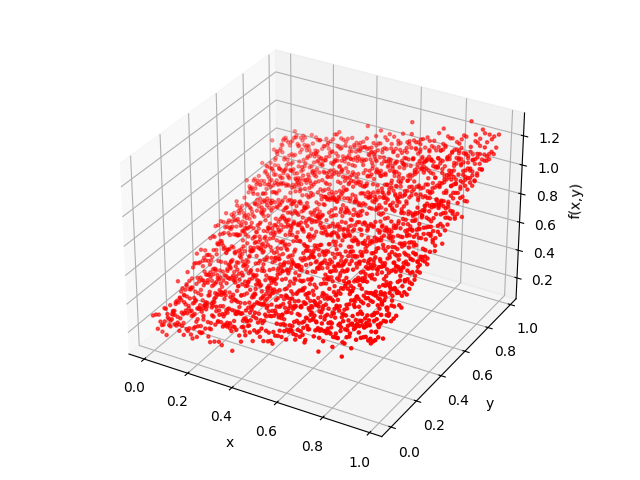

In [18]:
%matplotlib widget

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(Xg.flatten(), Yg.flatten(), fg.flatten(), s=5, c='red')

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('f(x,y)')

fig.tight_layout()
plt.show()
#plt.close()


In [19]:
X[:10], Y[:10], #fg[:10]  # Show the first 10 samples

(tensor([0.0000, 0.0200, 0.0400, 0.0600, 0.0800, 0.1000, 0.1200, 0.1400, 0.1600,
         0.1800]),
 tensor([0.0000, 0.0200, 0.0400, 0.0600, 0.0800, 0.1000, 0.1200, 0.1400, 0.1600,
         0.1800]))

In [20]:
# Split data into training and test sets
train_split = int(0.8 * X.shape[0])  # e.g. 40

# Create mask for the TRAIN square (top-left)
train_mask = (Xg < X[train_split]) & (Yg < Y[train_split])
test_mask  = ~train_mask

# Train points (1D vectors)
X_train = Xg[train_mask]
Y_train = Yg[train_mask]
f_train = fg[train_mask]

# Test block (bottom-right)
X_test  = Xg[test_mask]
Y_test  = Yg[test_mask]
f_test  = fg[test_mask]

print(X_train.shape, Y_train.shape, f_train.shape)
print(X_test.shape,  Y_test.shape,  f_test.shape)


torch.Size([1600]) torch.Size([1600]) torch.Size([1600])
torch.Size([900]) torch.Size([900]) torch.Size([900])


In [21]:
def plot_predictions_3d(train_X, train_Y, train_f,
                        test_X, test_Y, test_f,
                        predictions=None):
    """
    Plots training data, test data, and optional predictions in 3D.
    """
    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111, projection='3d')

    # Training data (blue)
    ax.scatter(train_X, train_Y, train_f,
               c='c', s=4, label='Training data')

    # Test data (green)
    ax.scatter(test_X, test_Y, test_f,
               c='g', s=4, label='Testing data')

    # Predictions (red)
    if predictions is not None:
        ax.scatter(test_X, test_Y, predictions,
                   c='r', s=4, label='Predictions')

    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('f(x,y)')

    ax.legend()
    plt.show()

# plot using plotly
import plotly.graph_objects as go

def plot_predictions_3d_plotly(train_X, train_Y, train_f,
                               test_X, test_Y, test_f,
                               predictions=None):
    fig = go.Figure()

    # Training data
    fig.add_trace(go.Scatter3d(
        x=train_X.detach().cpu().numpy(),
        y=train_Y.detach().cpu().numpy(),
        z=train_f.detach().cpu().numpy(),
        mode='markers',
        marker=dict(size=2, color='cyan', opacity=0.4),
        name='Training data'
    ))

    # Testing data
    fig.add_trace(go.Scatter3d(
        x=test_X.detach().cpu().numpy(),
        y=test_Y.detach().cpu().numpy(),
        z=test_f.detach().cpu().numpy(),
        mode='markers',
        marker=dict(size=3, color='green', opacity=0.6),
        name='Testing data'
    ))

    # Predictions
    if predictions is not None:
        pred = predictions.detach().cpu().reshape(-1)

        x_unique = torch.unique(test_X)
        y_unique = torch.unique(test_Y)

        # Check if full grid exists
        if pred.numel() == x_unique.numel() * y_unique.numel():
            # Surface case
            Xg, Yg = torch.meshgrid(x_unique, y_unique, indexing='ij')
            Zg = pred.reshape(Xg.shape)

            fig.add_trace(go.Surface(
                x=Xg.numpy(),
                y=Yg.numpy(),
                z=Zg.numpy(),
                colorscale='Reds',
                opacity=0.6,
                name='Prediction surface'
            ))
        else:
            # Scatter fallback (your current case)
            fig.add_trace(go.Scatter3d(
                x=test_X.detach().cpu().numpy(),
                y=test_Y.detach().cpu().numpy(),
                z=pred.numpy(),
                mode='markers',
                marker=dict(size=3, color='red'),
                name='Predictions'
            ))

    fig.update_layout(
        scene=dict(
            xaxis_title='x',
            yaxis_title='y',
            zaxis_title='f(x,y)'
        ),
        width=900,
        height=700,
        title='3D Regression Visualization'
    )

    fig.show()


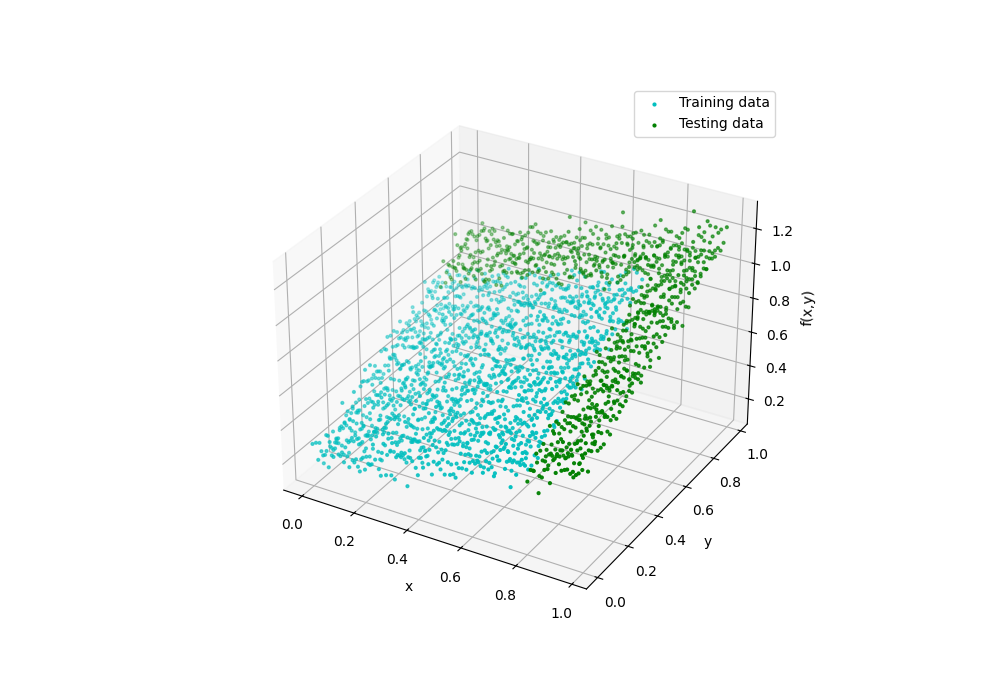

In [22]:

#Plot the training and test data
plot_predictions_3d(
    X_train, Y_train, f_train,
    X_test,  Y_test,  f_test
)

# Build a PyTorch linear model

In [23]:
# Create a linear model by subclassing nn.Module
class LinearRegressionModelYM(nn.Module):
    def __init__(self):
        super().__init__()
        # Define the model's layers. (x, y) as input so features = 2
        self.linear_layer = nn.Linear(in_features=2, out_features=1)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.linear_layer(x)


# Set random seed for reproducibility
torch.manual_seed(42)

# Create an instance of the model and send it to the target device
model_1 = LinearRegressionModelYM()
# Print out the model's parameters
list(model_1.parameters())

[Parameter containing:
 tensor([[0.5406, 0.5869]], requires_grad=True),
 Parameter containing:
 tensor([-0.1657], requires_grad=True)]

In [24]:
# Check the model current device
# next(model_1.parameters()).device

# Set the model to use the target device
model_1.to(device)
next(model_1.parameters()).device

device(type='cuda', index=0)

In [25]:
# Setup loss function
loss_fn = nn.L1Loss() # same as MAE

# Setup our optimizer
optimizer = torch.optim.SGD(params=model_1.parameters(), lr=0.01)

In [26]:
# Training loop
torch.manual_seed(42)

epochs = 500

# Put data on target device (device agnostic code for data)
X_train, Y_train, f_train  = X_train.to(device), Y_train.to(device), f_train.to(device)
X_test, Y_test, f_test = X_test.to(device), Y_test.to(device), f_test.to(device)

# Build input matrix (N,2)
test_inputs = torch.stack([X_test, Y_test], dim=1)
train_inputs = torch.stack([X_train, Y_train], dim=1)

# Loop through data
for epoch in range(epochs):
  model_1.train()

  # 1. Forword pass
  f_pred = model_1(train_inputs)

  # 2. Calculate loss
  loss = loss_fn(f_pred, f_train.unsqueeze(1))

  # 3. Optimizer zero grad
  optimizer.zero_grad()

  # 4. Perform backpropagation
  loss.backward()

  # 5. Optimizer step
  optimizer.step()

  ### Testing
  model_1.eval()
  with torch.inference_mode():
    test_pred = model_1(test_inputs)
    test_loss = loss_fn(test_pred, f_test.unsqueeze(1))

  # Print out what's happening
  if epoch % 10 == 0:
    print(f"Epoch: {epoch} | Loss: {loss} | Test loss: {test_loss}")

Epoch: 0 | Loss: 0.3150620460510254 | Test loss: 0.267925500869751
Epoch: 10 | Loss: 0.1848573237657547 | Test loss: 0.11697541922330856
Epoch: 20 | Loss: 0.081288181245327 | Test loss: 0.06067681312561035
Epoch: 30 | Loss: 0.062451303005218506 | Test loss: 0.07607249915599823
Epoch: 40 | Loss: 0.059610165655612946 | Test loss: 0.07943128049373627
Epoch: 50 | Loss: 0.057854991406202316 | Test loss: 0.07739884406328201
Epoch: 60 | Loss: 0.05625172331929207 | Test loss: 0.07383596897125244
Epoch: 70 | Loss: 0.05471964552998543 | Test loss: 0.07018040865659714
Epoch: 80 | Loss: 0.053311947733163834 | Test loss: 0.06713900715112686
Epoch: 90 | Loss: 0.05197136849164963 | Test loss: 0.06449692696332932
Epoch: 100 | Loss: 0.0507240854203701 | Test loss: 0.062081318348646164
Epoch: 110 | Loss: 0.049576111137866974 | Test loss: 0.059648141264915466
Epoch: 120 | Loss: 0.0485660545527935 | Test loss: 0.05750947818160057
Epoch: 130 | Loss: 0.04765352979302406 | Test loss: 0.05557437613606453
Epoc

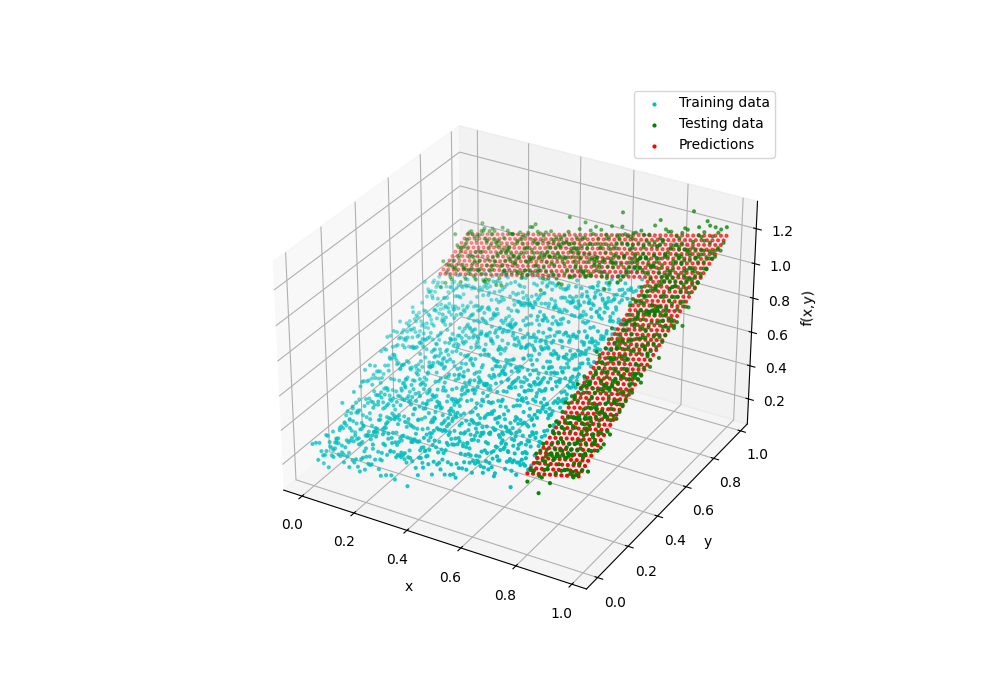

In [27]:
#Check out our model prediction visually

plot_predictions_3d(
    X_train.cpu(), Y_train.cpu(), f_train.cpu(),
    X_test.cpu(),  Y_test.cpu(),  f_test.cpu(),
    predictions=test_pred.squeeze(1).cpu()
)

plot_predictions_3d_plotly(
    X_train.cpu(), Y_train.cpu(), f_train.cpu(),
    X_test.cpu(),  Y_test.cpu(),  f_test.cpu(),
    predictions=test_pred.squeeze(1).cpu()
)